In [1]:
# Only look at the temperature data
# Make a HMM, RNN, and CNN on the data

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [11]:
hum_df = pd.read_csv("../data/historical-hourly-weather-data/humidity.csv",
                      index_col="datetime", parse_dates=["datetime"])
print("hum_df.size before filtering: ", hum_df.size)
hum_df = hum_df.between_time('11:30:00','12:30:00')
hum_df = hum_df[['Vancouver']]
hum_df = hum_df.rename(columns={"Vancouver": "van"})
print("hum_df.size after filtering for noon and NY: ", hum_df.size)
#print("Convert to fahrenheit")
#hum_df["ny_f"] = (hum_df["ny"] - 273.15) * (9/5.0) + 32
print(hum_df.head())

hum_df.size before filtering:  1629108
hum_df.size after filtering for noon and NY:  1886
                      van
datetime                 
2012-10-01 12:00:00   NaN
2012-10-02 12:00:00  89.0
2012-10-03 12:00:00  87.0
2012-10-04 12:00:00  43.0
2012-10-05 12:00:00  72.0


In [15]:
print("Number missing data points")
hum_df.van.isna().value_counts()

Number missing data points


False    1805
True       81
Name: van, dtype: int64

In [17]:
# Since there are very few, I will just impute to the median
hum_df = hum_df.assign(van_impute=hum_df.van.fillna(hum_df.van.median()))
print("Number missing data points after imputation")
hum_df.van_impute.isna().value_counts()

Number missing data points after imputation


False    1886
Name: van_impute, dtype: int64

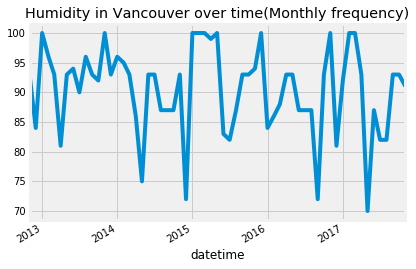

In [20]:
hum_df.van_impute.asfreq('M').plot()
plt.title('Humidity in Vancouver over time(Monthly frequency)')
plt.show()

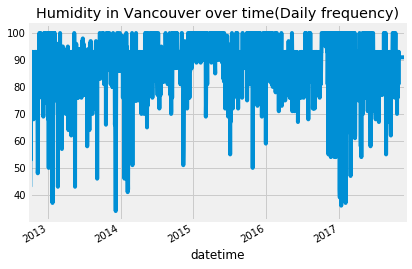

In [21]:
hum_df.van_impute.asfreq('D').plot()
plt.title('Humidity in Vancouver over time(Daily frequency)')
plt.show()

In [7]:
import tensorflow as tf
import tensorflow_probability as tfp

# Assign a hidden markov model to predict each season?

In [68]:
tfd = tfp.distributions

# Start with 2 states (high and low)
# And assume we know the probs
initial_distribution = tfd.Categorical(probs=[0.5, 0.5])

# Suppose a cold day has a 30% chance of being followed by a hot day
# and a hot day has a 20% chance of being followed by a cold day.
# We can model this as:
transition_distribution = tfd.Categorical(probs=[[0.95, 0.05],
                                                 [0.05, 0.95],
                                                ])

# Suppose additionally that on each day the temperature is
# normally distributed with mean and standard deviation 0 and 5 on
# a cold day and mean and standard deviation 15 and 10 on a hot day.
# We can model this with:

observation_distribution = tfd.Normal(loc=[95., 85.], scale=[5., 5.])

# Convert our observations into a tensor
observations = tf.convert_to_tensor(hum_df.van_impute)
observations = tf.cast(observations, tf.float32)
print(observations)

model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=1886)

tf.Tensor([91. 89. 87. ... 91. 91. 91.], shape=(1886,), dtype=float32)


In [69]:
fb = model.posterior_marginals(observations, mask=None, name=None)
fb.probs_parameter()

<tf.Tensor: id=1648072, shape=(1886, 2), dtype=float32, numpy=
array([[0.12781583, 0.87218416],
       [0.06162138, 0.9383786 ],
       [0.0150509 , 0.9849492 ],
       ...,
       [0.94922405, 0.05077592],
       [0.9315248 , 0.06847517],
       [0.90477675, 0.09522317]], dtype=float32)>

In [70]:
vv = model.posterior_mode(observations, mask=None, name=None)

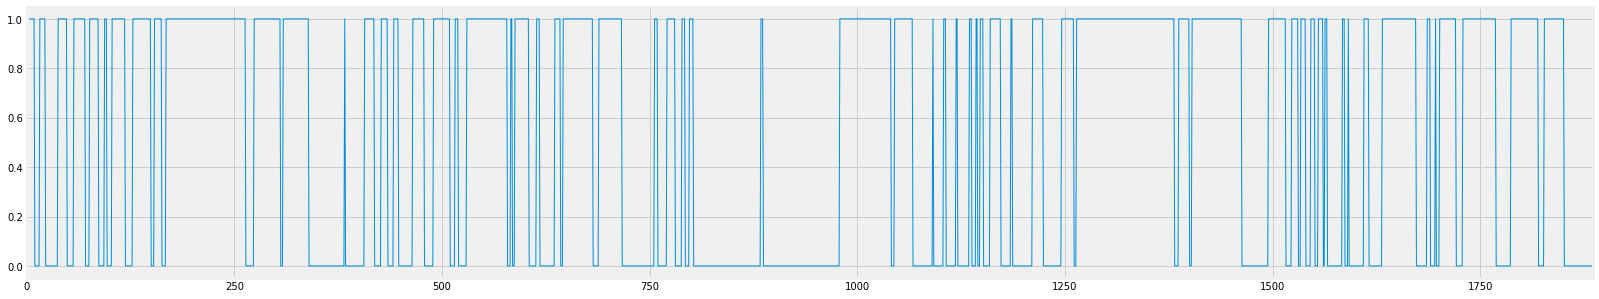

In [71]:
pd.Series(vv.numpy()).plot(figsize=(25, 5), linewidth=1)

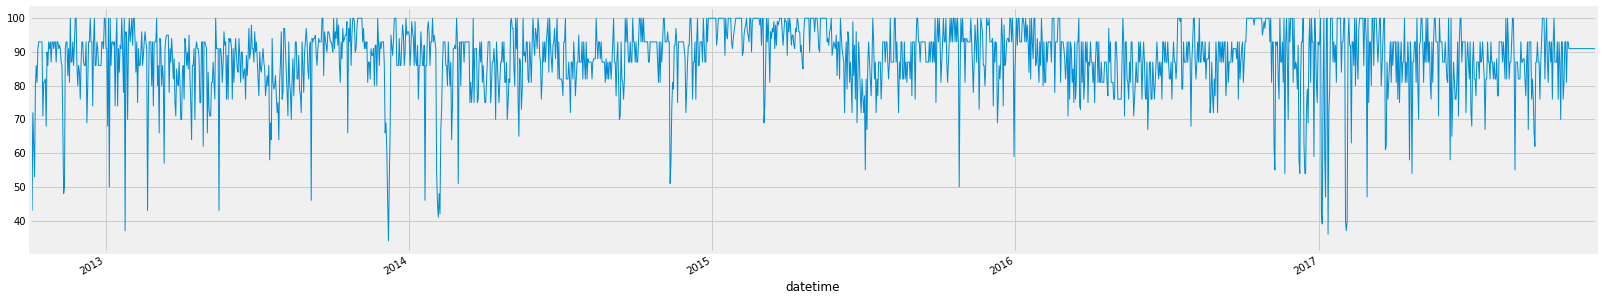

In [72]:
hum_df.van_impute.plot(figsize=(25, 5), linewidth=1)

In [115]:
# Now I want to get the likelihood of the most likely sequence
print(fb.probs_parameter().numpy())

max_loglike = tf.argmax(fb.probs_parameter(), axis=1)
max_loglike


[[0.12781583 0.87218416]
 [0.06162138 0.9383786 ]
 [0.0150509  0.9849492 ]
 ...
 [0.94922405 0.05077592]
 [0.9315248  0.06847517]
 [0.90477675 0.09522317]]


<tf.Tensor: id=1701049, shape=(1886,), dtype=int64, numpy=array([1, 1, 1, ..., 0, 0, 0])>

In [114]:
log_likelihood = sum(np.log(np.amax(fb.probs_parameter(), axis=1)))
log_likelihood

-172.98148607960113

In [ ]:
# Try training with Baum-Welch
# Ugh how

In [117]:
tfd = tfp.distributions

# Start with 2 states (high and low)
# And assume we know the probs
initial_distribution = tfd.Categorical(probs=[0.33, 0.33, 0.33])

# Suppose a cold day has a 30% chance of being followed by a hot day
# and a hot day has a 20% chance of being followed by a cold day.
# We can model this as:
transition_distribution = tfd.Categorical(probs=[[0.95, 0.025, 0.025],
                                                 [0.025, 0.95, 0.025],
                                                 [0.025, 0.025, 0.95]])

# Suppose additionally that on each day the temperature is
# normally distributed with mean and standard deviation 0 and 5 on
# a cold day and mean and standard deviation 15 and 10 on a hot day.
# We can model this with:

observation_distribution = tfd.Normal(loc=[95., 85., 75.], scale=[5., 5., 5.])

# Convert our observations into a tensor
observations = tf.convert_to_tensor(hum_df.van_impute)
observations = tf.cast(observations, tf.float32)
print(observations)

model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=1886)

vv = model.posterior_mode(observations, mask=None, name=None)

tf.Tensor([91. 89. 87. ... 91. 91. 91.], shape=(1886,), dtype=float32)


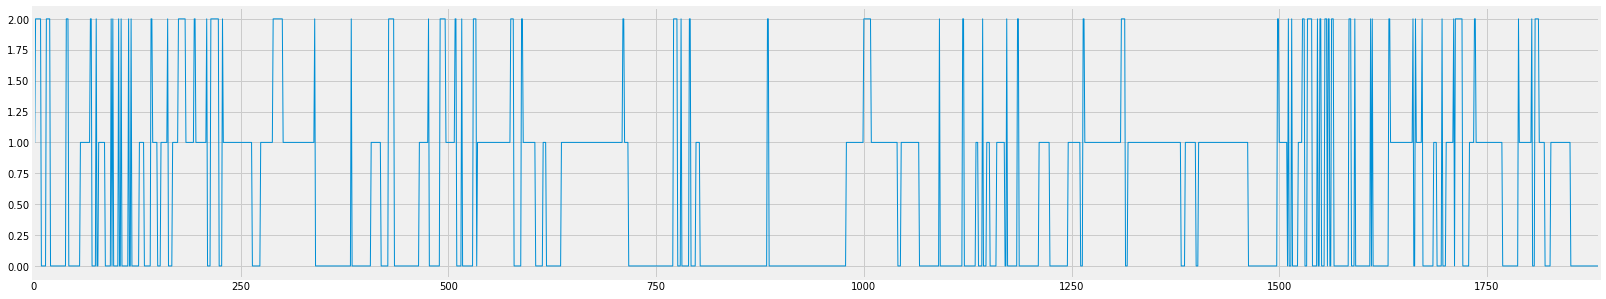

In [118]:
pd.Series(vv.numpy()).plot(figsize=(25, 5), linewidth=1)

In [119]:
log_likelihood = sum(np.log(np.amax(fb.probs_parameter(), axis=1)))
log_likelihood

-172.98148607960113